##  Step 1: Install Dependencies

In [ ]:
%%capture
# Uninstall conflicting packages
!pip uninstall -y peft bitsandbytes diffusers

# Install compatible versions
!pip install torch==2.1.2
!pip install transformers==4.36.2
!pip install datasets==2.16.1
!pip install accelerate==0.26.1
!pip install matplotlib seaborn

print("Packages installed!")

##  Step 2: Imports

In [2]:
import torch
import json
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime

from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    DataCollatorForLanguageModeling,
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print(f" PyTorch: {torch.__version__}")
print(f" CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" GPU: {torch.cuda.get_device_name(0)}")
    print(f" VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2026-02-07 14:56:45.086042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770476205.252525      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770476205.300809      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to registe

 PyTorch: 2.8.0+cu126
 CUDA: True
 GPU: Tesla T4
 VRAM: 14.6 GB


## Step 3: Configuration

In [ ]:
TRAIN_DATA_PATH = "/kaggle/input/freud-1-0/train.json"
VAL_DATA_PATH = "/kaggle/input/freud-1-0/validation.json"
OUTPUT_DIR = "./freud_gpt_neo_125m_output"
FINAL_MODEL_DIR = "./freud_gpt_neo_125m_final"
HF_MODEL_NAME = "Dalton-Khatri/freud-gpt-neo-125m"

# Model
BASE_MODEL = "EleutherAI/gpt-neo-125m"

# Training
NUM_EPOCHS = 3
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4
LEARNING_RATE = 5e-5  # Lower for full fine-tuning
WARMUP_RATIO = 0.1
MAX_SEQ_LENGTH = 512
WEIGHT_DECAY = 0.01

# Logging
LOGGING_STEPS = 20
EVALUATION_STEPS = 100
SAVE_STEPS = 500
SAVE_TOTAL_LIMIT = 2

print("⚙️ Configuration:")
print(f"   Model: {BASE_MODEL}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Batch: {BATCH_SIZE} × {GRADIENT_ACCUMULATION_STEPS} = {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"   LR: {LEARNING_RATE}")

⚙️ Configuration:
   Model: EleutherAI/gpt-neo-125m
   Training: FULL (not LoRA)
   Epochs: 3
   Batch: 4 × 4 = 16
   LR: 5e-05


##  Step 4: Metrics Callback

In [ ]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []
        self.learning_rates = []
        self.steps = []
        self.eval_steps = []
        self.perplexities = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.training_loss.append(logs['loss'])
                self.steps.append(state.global_step)
            if 'eval_loss' in logs:
                self.validation_loss.append(logs['eval_loss'])
                self.eval_steps.append(state.global_step)
                self.perplexities.append(np.exp(logs['eval_loss']))
            if 'learning_rate' in logs:
                self.learning_rates.append(logs['learning_rate'])
    
    def plot_metrics(self, save_path="training_metrics.png"):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Freud GPT-Neo 125M Training Metrics', fontsize=16, fontweight='bold')
        
        # Training Loss
        if self.training_loss:
            axes[0, 0].plot(self.steps, self.training_loss, 'b-', linewidth=2)
            axes[0, 0].set_xlabel('Steps')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].set_title('Training Loss')
            axes[0, 0].grid(True, alpha=0.3)
        
        # Validation Loss
        if self.validation_loss:
            axes[0, 1].plot(self.eval_steps, self.validation_loss, 'r-', linewidth=2, marker='o')
            axes[0, 1].set_xlabel('Steps')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].set_title('Validation Loss')
            axes[0, 1].grid(True, alpha=0.3)
        
        # Learning Rate
        if self.learning_rates:
            axes[1, 0].plot(self.steps, self.learning_rates, 'g-', linewidth=2)
            axes[1, 0].set_xlabel('Steps')
            axes[1, 0].set_ylabel('Learning Rate')
            axes[1, 0].set_title('Learning Rate Schedule')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        # Perplexity
        if self.perplexities:
            axes[1, 1].plot(self.eval_steps, self.perplexities, 'm-', linewidth=2, marker='s')
            axes[1, 1].set_xlabel('Steps')
            axes[1, 1].set_ylabel('Perplexity')
            axes[1, 1].set_title('Perplexity (Lower = Better)')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n Saved metrics to: {save_path}")
        plt.show()
    
    def get_summary(self):
        return {
            'final_training_loss': self.training_loss[-1] if self.training_loss else None,
            'final_validation_loss': self.validation_loss[-1] if self.validation_loss else None,
            'best_validation_loss': min(self.validation_loss) if self.validation_loss else None,
            'final_perplexity': self.perplexities[-1] if self.perplexities else None,
            'best_perplexity': min(self.perplexities) if self.perplexities else None,
        }

metrics_callback = MetricsCallback()
print("✅ Metrics callback ready")

✅ Metrics callback ready


## Step 5: Load Data

In [ ]:
print(" Loading data\n")

with open(TRAIN_DATA_PATH, 'r') as f:
    train_data = json.load(f)
with open(VAL_DATA_PATH, 'r') as f:
    val_data = json.load(f)

print(f" Loaded:")
print(f"   Train: {len(train_data):,} samples")
print(f"   Val: {len(val_data):,} samples")
print(f"\n Sample:")
print(train_data[0]['text'][:300] + "...")

📂 Loading data...

✅ Loaded:
   Train: 10,025 samples
   Val: 1,114 samples

📄 Sample:
<|system|>: You are Freud, a calm, empathetic therapeutic AI assistant. You respond thoughtfully, kindly, and supportively. You ask gentle follow-up questions and never judge the user.
<|user|>:
[emotion: done]
That's the end of my input.
<|assistant|>:
Alright, take care and goodbye.
<|user|>:
[emo...


##  Step 6: Load Model & Tokenizer

In [ ]:
print(f" Loading {BASE_MODEL}\n")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f" Tokenizer loaded (vocab: {len(tokenizer):,})")

# Model
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None,
    trust_remote_code=True,
)

# Set pad token in model config
model.config.pad_token_id = tokenizer.pad_token_id

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f" Model loaded")
print(f"   Total params: {total_params:,}")
print(f"   Trainable: {trainable_params:,} (100%)")
print(f"   Size: ~{total_params * 2 / 1024**2:.0f} MB")

🤖 Loading EleutherAI/gpt-neo-125m...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

✅ Tokenizer loaded (vocab: 50,257)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

✅ Model loaded
   Total params: 125,198,592
   Trainable: 125,198,592 (100%)
   Size: ~239 MB


##  Step 7: Tokenize Data

In [ ]:
print(" Tokenizing data\n")

def tokenize_function(examples):
    # Tokenize with padding and truncation
    result = tokenizer(
        examples['text'],
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding='max_length',  # Pad to same length
    )
    # For causal LM, labels = input_ids
    result['labels'] = result['input_ids'].copy()
    return result

# Create datasets
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# Tokenize
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train"
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing val"
)

print(f" Tokenized")
print(f" Train: {len(train_dataset)} samples")
print(f" Val: {len(val_dataset)} samples")

🔧 Tokenizing data...



Tokenizing train:   0%|          | 0/10025 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/1114 [00:00<?, ? examples/s]

✅ Tokenized
   Train: 10025 samples
   Val: 1114 samples


##  Step 8: Training Setup

In [ ]:
print(" Setting up training\n")

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal LM, not masked LM
)

# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Training
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    
    # Optimization
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",
    
    # Mixed precision 
    bf16=torch.cuda.is_available(),
    fp16=False,
    
    # Logging
    logging_steps=LOGGING_STEPS,
    logging_dir=f"{OUTPUT_DIR}/logs",
    evaluation_strategy="steps",
    eval_steps=EVALUATION_STEPS,
    
    # Saving
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=SAVE_TOTAL_LIMIT,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    
    # Misc
    gradient_checkpointing=False,  # Not needed for 125M
    optim="adamw_torch",
    report_to="none",
    seed=42,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[metrics_callback],
)

print(" Trainer ready")

⚙️ Setting up training...

✅ Trainer ready


##  Step 9: Train!

In [ ]:
print("="*80)
print(" STARTING TRAINING")
print("="*80)
print(f"Start: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nEstimated: ~30-45 mins (GPU), ~2-3 hours (CPU)\n")

# Train!
train_result = trainer.train()

print("\n" + "="*80)
print(" TRAINING COMPLETE!")
print("="*80)
print(f"End: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🎬 STARTING TRAINING
Start: 2026-02-07 14:57:02

Estimated: ~30-45 mins (GPU), ~2-3 hours (CPU)



You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,2.888000,2.727768
200,0.878200,0.857163
300,0.769300,0.752207
400,0.703400,0.707537
500,0.672300,0.678106
600,0.657600,0.659581
700,0.612700,0.646488
800,0.600100,0.636496
900,0.628400,0.630906
1000,0.606000,0.626871


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



🎉 TRAINING COMPLETE!
End: 2026-02-07 17:07:25


##  Step 10: Visualize Metrics

📊 Creating visualizations...


📊 Saved metrics to: ./freud_gpt_neo_125m_output/training_metrics.png


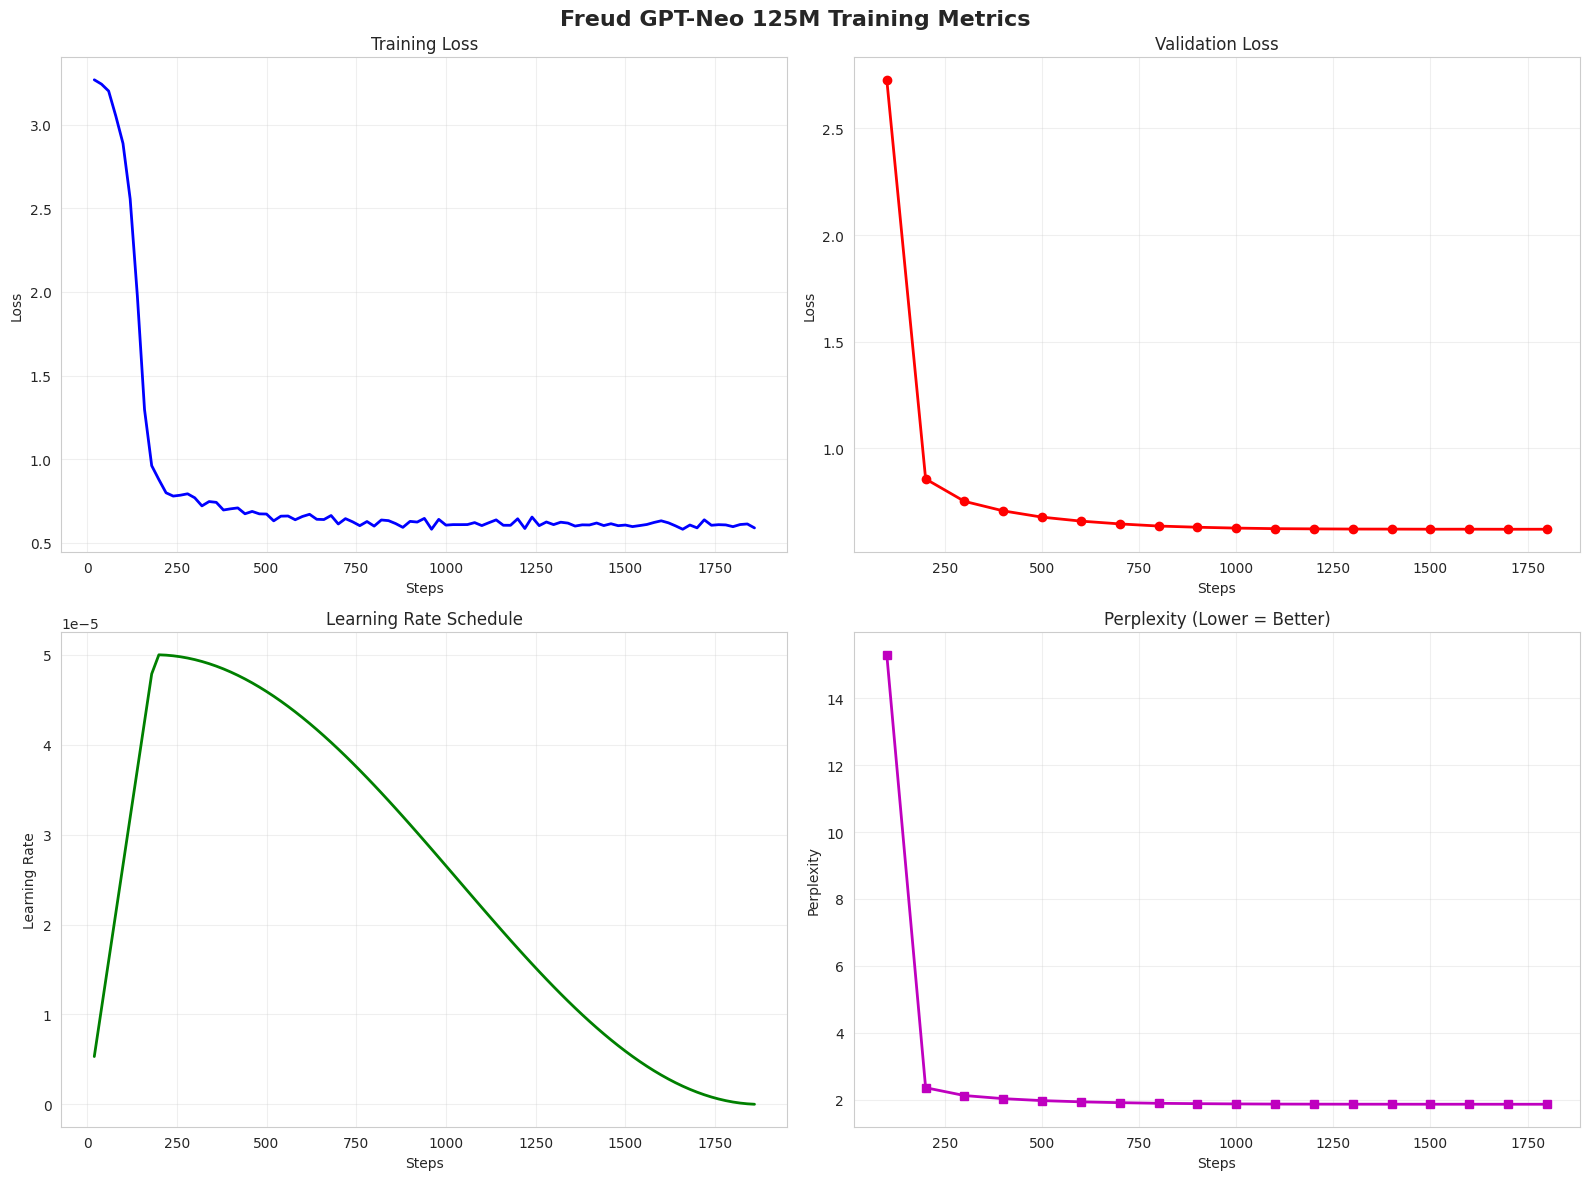


📈 TRAINING SUMMARY

Final Training Loss: 0.5893
Final Validation Loss: 0.6215
Best Validation Loss: 0.6214
Final Perplexity: 1.86
Best Perplexity: 1.86

✅ Excellent! Perplexity < 10

💾 Summary saved


In [ ]:
print(" Creating visualizations...\n")

metrics_callback.plot_metrics(f"{OUTPUT_DIR}/training_metrics.png")

summary = metrics_callback.get_summary()

print("\n" + "="*80)
print(" TRAINING SUMMARY")
print("="*80)
print(f"\nFinal Training Loss: {summary['final_training_loss']:.4f}")
print(f"Final Validation Loss: {summary['final_validation_loss']:.4f}")
print(f"Best Validation Loss: {summary['best_validation_loss']:.4f}")
print(f"Final Perplexity: {summary['final_perplexity']:.2f}")
print(f"Best Perplexity: {summary['best_perplexity']:.2f}")

# Quality check
if summary['final_perplexity'] < 10:
    print("\n Excellent! Perplexity < 10")
elif summary['final_perplexity'] < 20:
    print("\n Good! Perplexity < 20")
elif summary['final_perplexity'] < 30:
    print("\n  Fair. Perplexity < 30")
else:
    print("\n Poor. Consider retraining")

with open(f"{OUTPUT_DIR}/summary.json", 'w') as f:
    json.dump(summary, f, indent=2)
print(f"\n Summary saved")

##  Step 11: Save Model

In [ ]:
print(" Saving final model...\n")

os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print(f" Model saved to: {FINAL_MODEL_DIR}")
print("\n Files:")
for f in os.listdir(FINAL_MODEL_DIR):
    size = os.path.getsize(os.path.join(FINAL_MODEL_DIR, f)) / (1024**2)
    print(f"   {f} ({size:.1f} MB)")

💾 Saving final model...

✅ Model saved to: ./freud_gpt_neo_125m_final

📦 Files:
   model.safetensors (238.8 MB)
   special_tokens_map.json (0.0 MB)
   vocab.json (0.8 MB)
   merges.txt (0.4 MB)
   training_args.bin (0.0 MB)
   config.json (0.0 MB)
   tokenizer.json (2.0 MB)
   tokenizer_config.json (0.0 MB)
   generation_config.json (0.0 MB)


##  Step 12: Test Model

In [ ]:
print(" Testing model...\n")

test_prompts = [
    ("sad", "I feel really lonely today"),
    ("anxious", "I'm worried about my exams"),
]

SYSTEM_PROMPT = (
    "You are Freud, a calm, empathetic therapeutic AI assistant. "
    "You respond thoughtfully, kindly, and supportively. "
    "You ask gentle follow-up questions and never judge the user."
)

for emotion, message in test_prompts:
    prompt = f"""<|system|>: {SYSTEM_PROMPT}
<|user|>:
[emotion: {emotion}]
{message}
<|assistant|>:
"""
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    if torch.cuda.is_available():
        inputs = inputs.to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=100,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,  # CRITICAL!
            repetition_penalty=1.2,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.replace(prompt, "").strip()
    if "<|user|>" in response:
        response = response.split("<|user|>")[0].strip()
    
    print(f"User: {message}")
    print(f"Freud: {response}")
    print()

🧪 Testing model...



/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


User: I feel really lonely today
Freud: You're feeling so lonely

User: I'm worried about my exams
Freud: Feeling anxious can be tough. What's been making you feel this way?



In [13]:
import shutil
shutil.make_archive('freud_model_neo_gpt', 'zip', '/kaggle/working/freud_gpt_neo_125m_final')

'/kaggle/working/freud_model_neo_gpt.zip'

In [14]:
from IPython.display import FileLink

FileLink(r'freud_model_neo_gpt.zip')

/kaggle/working/freud_model_neo_gpt.zip